In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

sales = pd.read_csv('../data/processed/US_EV_SalesData.csv')

socioeconomic = pd.read_csv('../data/processed/state_year.csv')
socioeconomic['Stations Opened'] = socioeconomic['Stations Opened'].fillna(value=0)

data = pd.merge(sales, socioeconomic)
data = data[data['Year'] < 2020]


li_price = pd.read_csv('../data/processed/li_price.csv')
li_price.index = li_price['Year']
li_price = li_price.drop(columns=['Year'])
li_price = li_price.to_dict()['Price']

data['Li Battery Price'] = data['Year'].map(li_price)

PREDICTORS = ['Gasoline Price', 'Median Income', 'Population', 'Renewable Energy Use', 'Transportation Energy Use', 'Stations Opened']#, 'Li Battery Price']
RESPONSES = ['BEV sales', 'PHEV sales', 'Total']

MODELS = ['OLS', 'Log-log', 'Random forest']

all_scores = {'State': data['State'].unique(),
              **{model: [] for model in MODELS}}
predictions = {model: {year: 0 for year in data['Year'].unique()}\
               for model in MODELS}

In [2]:
fresh_data = pd.read_csv('../data/interim/socioeconomic_min_aicc_results.csv')
fresh_data = fresh_data.set_index(['Year', 'State', 'Prediction Years Out', 'Attribute'])
fresh_data = fresh_data[['Prediction']]
fresh_data = fresh_data.to_dict()['Prediction']
# print(fresh_data)
def gen_data(base_year, state, lookahead):
    d = {factor: [fresh_data[(base_year + i, state, i, factor)]
                  for i in range(1, lookahead + 1)]
         for factor in PREDICTORS}
    d['Year'] = [base_year + i for i in range(1, lookahead + 1)]
    df = pd.DataFrame(d)
    df['State'] = state
    return df

gen_data(2013, 'WI', 2)

,Gasoline Price,Median Income,Population,Renewable Energy Use,Transportation Energy Use,Stations Opened,Year,State
0,30.3884,30577.753414,5.753169e+06,212921.150928,412955.791667,-3.732961,2014,WI
1,31.2668,29663.397830,5.766317e+06,218361.814856,409613.375000,24.755029,2015,WI


## Ordinary Least Squares Linear Regression

In [32]:
coef = None
for state in data['State'].unique():
    scores = []

    for lo in data['Year'].unique():
        hi = lo + 5
        if hi > data['Year'].max():
            break

        subset = data[(data['State'] == state) & (lo <= data['Year']) & (data['Year'] < hi)]
        train, test = train_test_split(subset, test_size=0.4, shuffle=False)

        for response in RESPONSES:
            mod = LinearRegression().fit(train[PREDICTORS], train[[response]])
            new = gen_data(lo + 2, state, 2)
            predict = mod.predict(new[PREDICTORS])

            if coef is None:
                coef = mod.coef_
            else:
                coef += mod.coef_

            scores.append(np.sqrt(mean_squared_error(test[response], predict)))

            if response == 'Total':
                new = gen_data(lo + 2, state, 1)
                predictions['OLS'][lo + 3] += mod.predict(test[PREDICTORS])[0][0]

    all_scores['OLS'].append(sum(scores) / len(scores))

# train, _ = train_test_split(data[(2011 <= data['Year']) & (data['Year'] < 2015)])
# mod = LinearRegression().fit(train[PREDICTORS], train['Total'])

for c, x in zip(coef[0], PREDICTORS):
    print(f"{c} * {x}")

0.26364296796959424 * Gasoline Price
0.019505316414549032 * Median Income
0.09439832924278785 * Population
0.4216678633962331 * Renewable Energy Use
-0.9802492023693147 * Transportation Energy Use
-0.007518506264027199 * Stations Opened


## Power Regression

In [33]:
coef = None
lndata = pd.DataFrame()
for c in data.columns:
    if c in PREDICTORS or c in RESPONSES: lndata[c] = np.log(data[c] + 5)
    else: lndata[c] = data[c]

for state in data['State'].unique():
    scores = []

    for lo in data['Year'].unique():
        hi = lo + 5
        if hi > data['Year'].max():
            break

        subset = lndata[(lndata['State'] == state) & (lo <= lndata['Year']) & (lndata['Year'] < hi)]
        train, test = train_test_split(subset, test_size=0.4, shuffle=False)
        # print(len(train), len(test))
        for response in RESPONSES:
            mod = LinearRegression().fit(train[PREDICTORS], train[[response]])

            if coef is None:
                coef = mod.coef_
            else:
                coef += mod.coef_

            new = gen_data(lo + 2, state, 2)
            ln_new = pd.DataFrame()
            for c in new.columns:
                if c in PREDICTORS or c in RESPONSES: ln_new[c] = np.log(new[c] + 5)
                else: ln_new[c] = new[c]
            predict = mod.predict(ln_new[PREDICTORS])

            scores.append(np.sqrt(mean_squared_error(
                np.exp(test[response]) - 5, np.exp(predict)
            )))

            if response == 'Total':
                predictions['Log-log'][lo + 3] += np.exp(mod.predict(test[PREDICTORS]))[0][0]

    all_scores['Log-log'].append(sum(scores) / len(scores))

for c, x in zip(coef[0], PREDICTORS):
    print(f"{c} * ln({x})")

200.46088973978544 * ln(Gasoline Price)
-483.7599743869185 * ln(Median Income)
-2.056698265399458 * ln(Population)
-95.57741060932874 * ln(Renewable Energy Use)
-385.4770378368685 * ln(Transportation Energy Use)
-0.5419609621861065 * ln(Stations Opened)


## Random Forest Regression

In [36]:
coef = None
for state in data['State'].unique():
    scores = []

    for lo in data['Year'].unique():
        hi = lo + 5
        if hi > data['Year'].max():
            break

        subset = data[(data['State'] == state) & (lo <= data['Year']) & (data['Year'] < hi)]
        train, test = train_test_split(subset, test_size=0.4, shuffle=False)

        for response in RESPONSES:
            mod = RandomForestRegressor().fit(train[PREDICTORS], train[[response]].values.ravel())

            if coef is None:
                coef = mod.feature_importances_
            else:
                coef += mod.feature_importances_

            new = gen_data(lo + 2, state, 2)
            predict = mod.predict(new[PREDICTORS])
            scores.append(np.sqrt(mean_squared_error(test[response], predict)))

            if response == 'Total':
                test = gen_data(lo + 2, state, 1)
                predictions['Random forest'][lo + 3] += mod.predict(test[PREDICTORS])[0]

    all_scores['Random forest'].append(sum(scores) / len(scores))

for c, x in zip(coef, PREDICTORS):
    print(f"{c}: {x})")

30.12017602083088: Gasoline Price)
30.314445120629983: Median Income)
30.181393558909654: Population)
29.323589656749686: Renewable Energy Use)
31.07047842871593: Transportation Energy Use)
28.989917214163825: Stations Opened)


## Per-State root-mean-squared-loss

In [6]:
pd.DataFrame.from_dict(all_scores)

,State,OLS,Log-log,Random forest
0,AR,70.422977,74.310263,62.372545
1,IL,1069.874792,3762.143974,984.564364
2,IN,277.946101,773.766642,254.729688
3,IA,156.563279,416.569304,117.325692
4,LA,108.514765,79.699978,88.225899
5,MI,1071.585606,1035.830665,511.060350
6,MN,1080.653163,2297.608190,468.087962
7,MS,42.378883,71.519984,37.366327
8,MO,228.372112,308.071488,315.846050
9,ND,13.500916,8.118926,11.992765


## Aggregate predictions vs. True predictions

In [7]:
total_sales = data[['Year', 'Total']]
total_sales = pd.pivot_table(total_sales, values='Total', index='Year', aggfunc=np.sum)
result = pd.merge(left=total_sales, right=pd.DataFrame(predictions), left_index=True, right_index=True)
result = result[result['OLS'] != 0.0]
result

,Total,OLS,Log-log,Random forest
Year,,,,
2014,12355,14328.503579,11069.815724,9238.29
2015,10744,11904.744705,15790.417882,11446.55
2016,15527,9232.319754,12955.960981,11025.27
2017,18920,20890.859503,15633.252564,14263.63


In [18]:
result['OLS Error'] = np.abs(result['OLS'] - result['Total'])
result['LL Error'] = np.abs(result['Log-log'] - result['Total'])
result['RF Error'] = np.abs(result['Random forest'] - result['Total'])

In [21]:
result[['OLS Error', 'LL Error', 'RF Error']].sum()

OLS Error    11399.788033
LL Error     12189.388613
RF Error     12977.360000
dtype: float64

<AxesSubplot:xlabel='Year'>

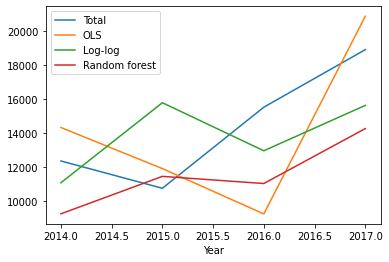

In [8]:
result.plot.line()